<div align="right"><i>Бронников Егор ПМ-1901</i></div>

# Извлечение признаков из временного ряда 

## Импорт модулей

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

## Данные

In [2]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
passengers.columns = ["y"]

In [3]:
passengers.head()

,y
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


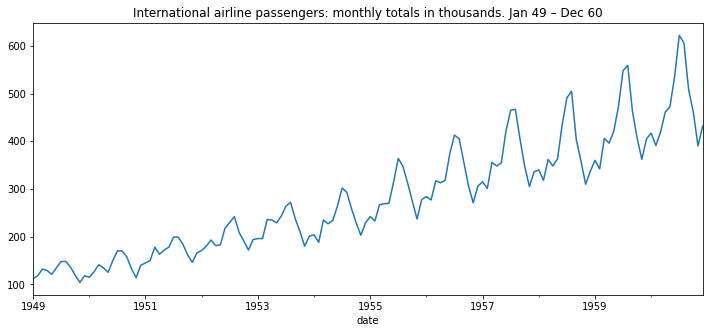

In [4]:
passengers["y"].plot(figsize=(12,5))
plt.title("International airline passengers: monthly totals in thousands. Jan 49 – Dec 60")
plt.show()

## Задание 1

## Фурье-преобразование

In [5]:
s = 12

passlen = len(passengers)
phi = [np.sin((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
psi = [np.cos((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
x1 = list(range(1, len(passengers) + 1))

# passengers["const"] = 1
passengers["x1"] = x1
passengers["phi"] = phi
passengers["psi"] = psi

In [6]:
passengers.head()

,y,x1,phi,psi
date,,,,
1949-01-01,112,1,0.000000,1.000000e+00
1949-02-01,118,2,0.500000,8.660254e-01
1949-03-01,132,3,0.866025,5.000000e-01
1949-04-01,129,4,1.000000,6.123234e-17
1949-05-01,121,5,0.866025,-5.000000e-01


### Подбор параметров

In [7]:
def mse(data, theta0, theta1, beta1, beta2):
    return np.mean((data["y"] - (theta0 + theta1*data["x1"] + beta1*data["phi"] + beta2*data["psi"]))**2)

In [8]:
opfunc = lambda x: mse(passengers, x[0], x[1], x[2], x[3])

optimization = minimize(opfunc, (0, 0, 0, 0))

print(optimization)
theta0, theta1, beta1, beta2 = optimization.x

      fun: 1042.0664148569094
 hess_inv: array([[ 2.16199880e+00, -2.26887084e-02,  1.13830718e-01,
         5.84308704e-03],
       [-2.26887084e-02,  3.09821489e-04, -9.88384656e-04,
         3.76018230e-05],
       [ 1.13830718e-01, -9.88384656e-04,  9.68934013e-01,
         8.17598521e-02],
       [ 5.84308704e-03,  3.76018230e-05,  8.17598521e-02,
         1.00643150e+00]])
      jac: array([0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 105
      nit: 12
     njev: 21
   status: 0
  success: True
        x: array([ 88.18246327,   2.64987789,   5.42625932, -45.49952248])


**Среднеквадратичная ошибка**

In [9]:
print(f"MSE: {optimization.fun}")

MSE: 1042.0664148569094


In [10]:
approx = theta0 + theta1*passengers["x1"] + beta1*passengers["phi"] + beta2*passengers["psi"]

### Аппроксимация

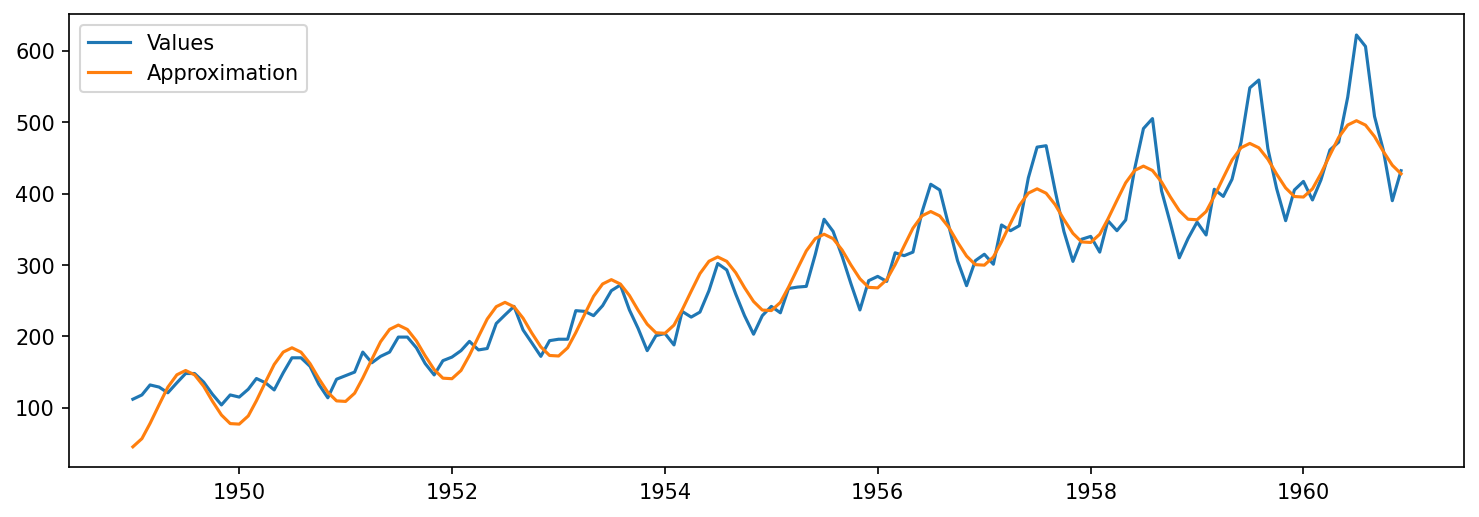

In [11]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

### Прогноз

In [12]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [14]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

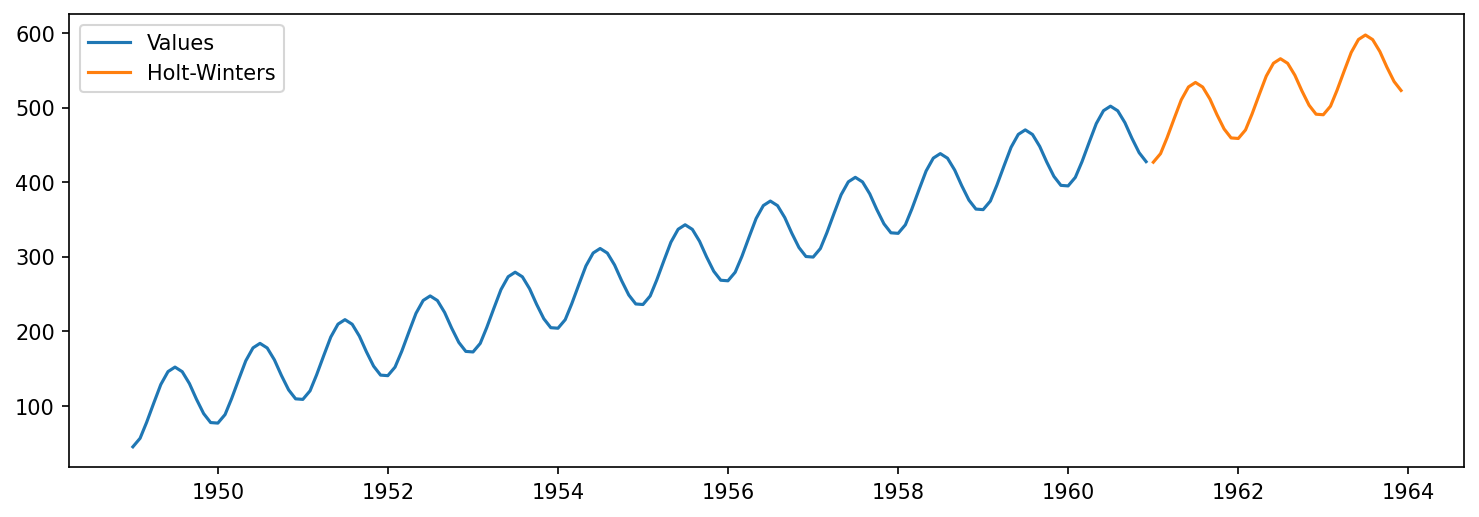

In [15]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

### Анализ остатков

In [16]:
res = passengers["y"] - approx

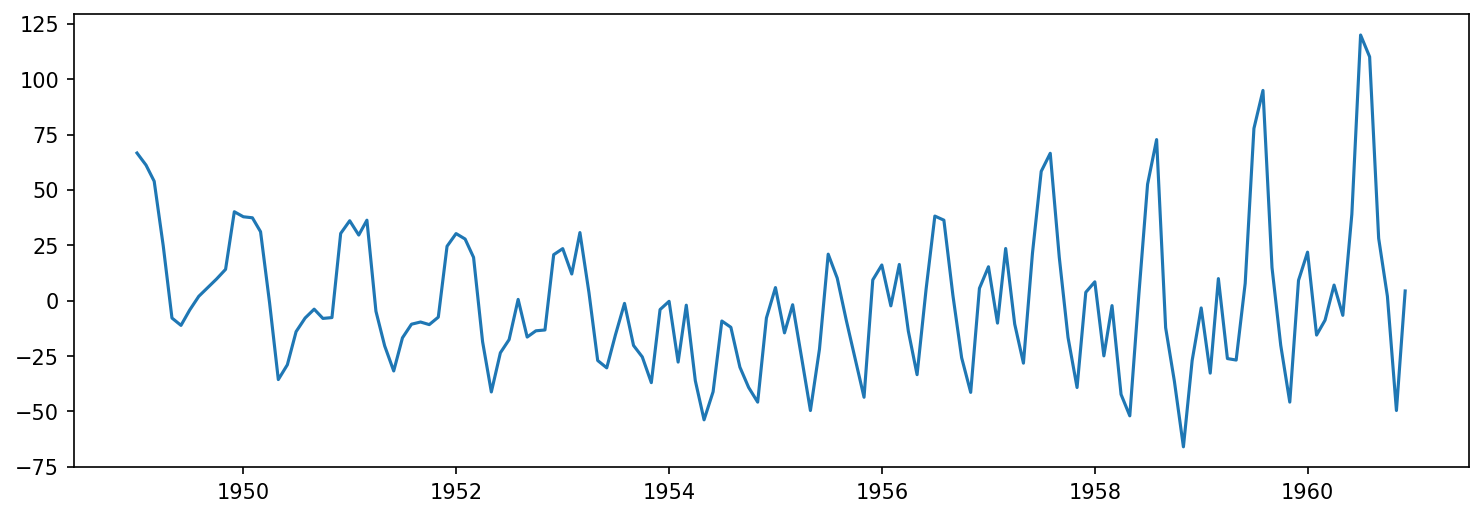

In [17]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(res)
plt.show()

## One-Hot-Encoding

### Данные

In [18]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [19]:
df = pd.get_dummies(passengers.index.month).set_index(passengers.index)

In [20]:
df["y"] = passengers["num_passengers"]

In [21]:
df.columns = [f"x{i}"for i in range(1, 13)] + ["y"]

In [22]:
df["t"] = [i for i in range(1, len(df)+1)]

In [23]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y,t
date,,,,,,,,,,,,,,
1949-01-01,1,0,0,0,0,0,0,0,0,0,0,0,112,1
1949-02-01,0,1,0,0,0,0,0,0,0,0,0,0,118,2
1949-03-01,0,0,1,0,0,0,0,0,0,0,0,0,132,3
1949-04-01,0,0,0,1,0,0,0,0,0,0,0,0,129,4
1949-05-01,0,0,0,0,1,0,0,0,0,0,0,0,121,5


### Подбор параметров

In [24]:
def mse(data, var):
    return np.mean((data["y"] - (var[0] + sum(var[i]*data[f"x{i}"] for i in range(1, 12)) + var[-1]*data["t"]))**2)

In [25]:
opfunc = lambda x: mse(df, x)

optimization = minimize(opfunc, [0 for i in range(13)])

print(optimization)
var = optimization.x

      fun: 630.6943908235233
 hess_inv: array([[ 3.03102585e+00, -1.05991388e+00, -7.33318621e-01,
        -1.15281536e+00, -8.43660548e-01, -1.11935835e+00,
        -1.28760450e+00, -1.35023015e+00, -1.43330947e+00,
        -1.18104487e+00, -9.89967383e-01, -5.98651117e-01,
        -2.19912139e-02],
       [-1.05991388e+00,  2.72862849e+00,  1.23174486e+00,
         1.37620470e+00,  8.73796102e-01,  1.02128001e+00,
         8.40510384e-01,  5.44684698e-01,  4.87028055e-01,
         3.08521984e-01,  1.30385321e-01, -2.74564338e-01,
         3.32436350e-03],
       [-7.33318621e-01,  1.23174486e+00,  1.78443873e+00,
         9.09422348e-01,  4.49112274e-01,  6.54344106e-01,
         4.24795291e-01,  7.48312077e-02,  7.39665908e-02,
         7.18857712e-02,  3.75117522e-02, -2.41500093e-01,
         3.18401069e-03],
       [-1.15281536e+00,  1.37620470e+00,  9.09422348e-01,
         2.27948519e+00,  8.28813613e-01,  1.03412156e+00,
         1.12261149e+00,  1.08987682e+00,  1.08526461e+0

**Среднеквадратичная ошибка**

In [26]:
print(f"MSE: {optimization.fun}")

MSE: 630.6943908235233


### Аппроксимация

In [27]:
approx = var[0] + sum(var[i]*df[f"x{i}"] for i in range(1, 13)) + var[-1]*df["t"]

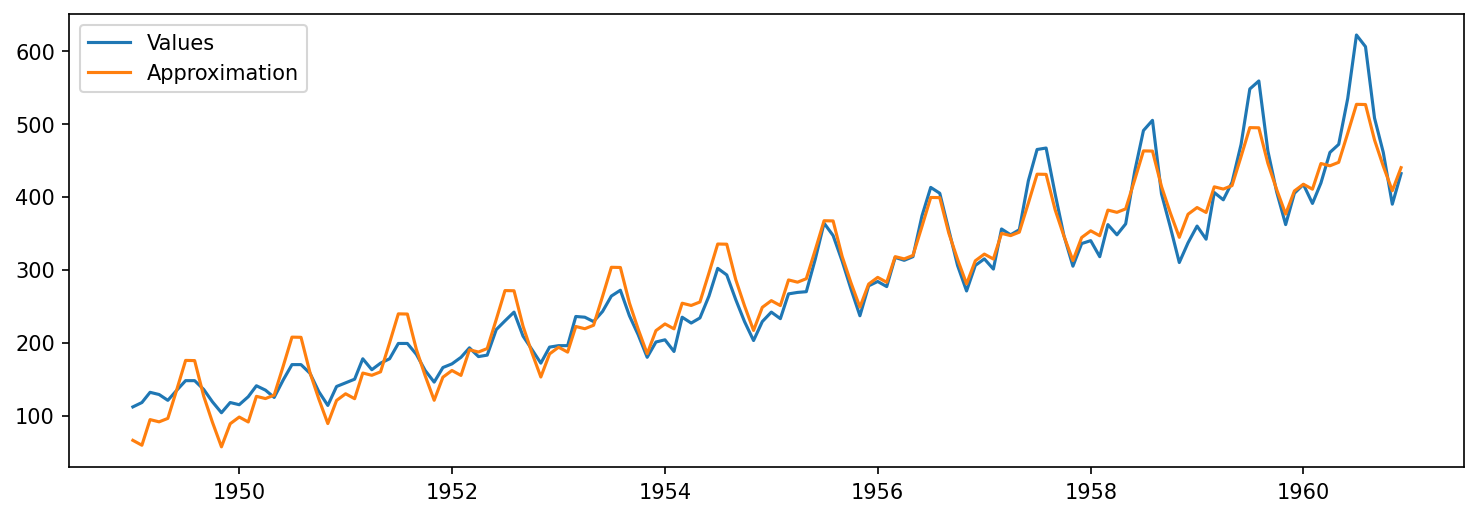

In [28]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

### Прогноз

In [29]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [31]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

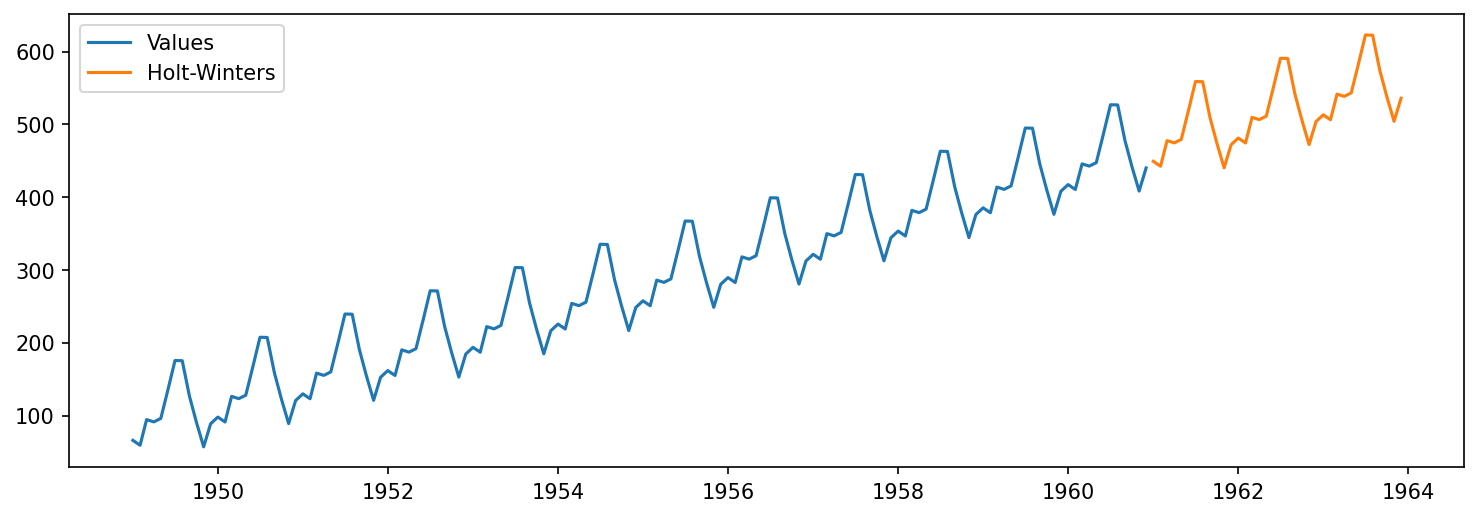

In [32]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

## Задание 2

## Данные

In [33]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)
passengers.columns = ["y"]

## Фурье-преобразование

In [34]:
s = 12

passlen = len(passengers)
phi = [np.sin((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
psi = [np.cos((2*np.pi*(i-1))/s) for i in range(1, passlen + 1)]
x1 = list(range(1, len(passengers) + 1))

# passengers["const"] = 1
passengers["x1"] = x1
passengers["phi"] = phi
passengers["psi"] = psi

### Подбор параметров

In [35]:
def mse(data, theta0, theta1, beta1, beta2):
    return np.mean((data["y"] - (theta0 * theta1**data["x1"] * beta1**data["phi"] * beta2**data["psi"]))**2)

In [36]:
opfunc = lambda x: mse(passengers, x[0], x[1], x[2], x[3])

optimization = minimize(opfunc, (1, 1, 1, 1))

print(optimization)
theta0, theta1, beta1, beta2 = optimization.x

      fun: 649.2251797812772
 hess_inv: array([[ 9.33464154e-01, -6.59913831e-05, -4.60351112e-04,
         2.09919209e-04],
       [-6.59913831e-05,  5.15255798e-09,  3.40149920e-08,
         1.47232825e-09],
       [-4.60351112e-04,  3.40149920e-08,  1.08719186e-05,
         2.46875257e-07],
       [ 2.09919209e-04,  1.47232825e-09,  2.46875257e-07,
         8.49475918e-06]])
      jac: array([ 6.71386719e-04,  1.46069107e+01,  1.26655579e-01, -1.85470581e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 467
      nit: 34
     njev: 91
   status: 2
  success: False
        x: array([129.23134054,   1.00955793,   1.01091479,   0.83548715])


**Среднеквадратичная ошибка**

In [37]:
print(f"MSE: {optimization.fun}")

MSE: 649.2251797812772


In [38]:
approx = theta0 * theta1**passengers["x1"] * beta1**passengers["phi"] * beta2**passengers["psi"]

### Аппроксимация

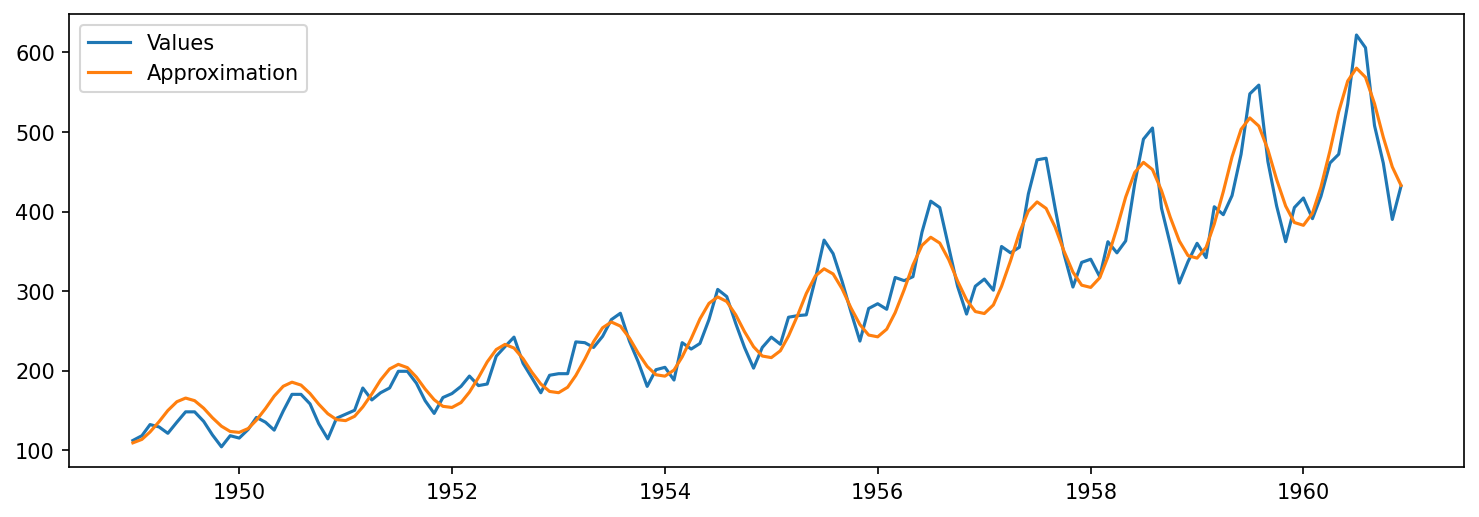

In [39]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(passengers["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

### Прогноз

In [40]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="mul").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [41]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [42]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

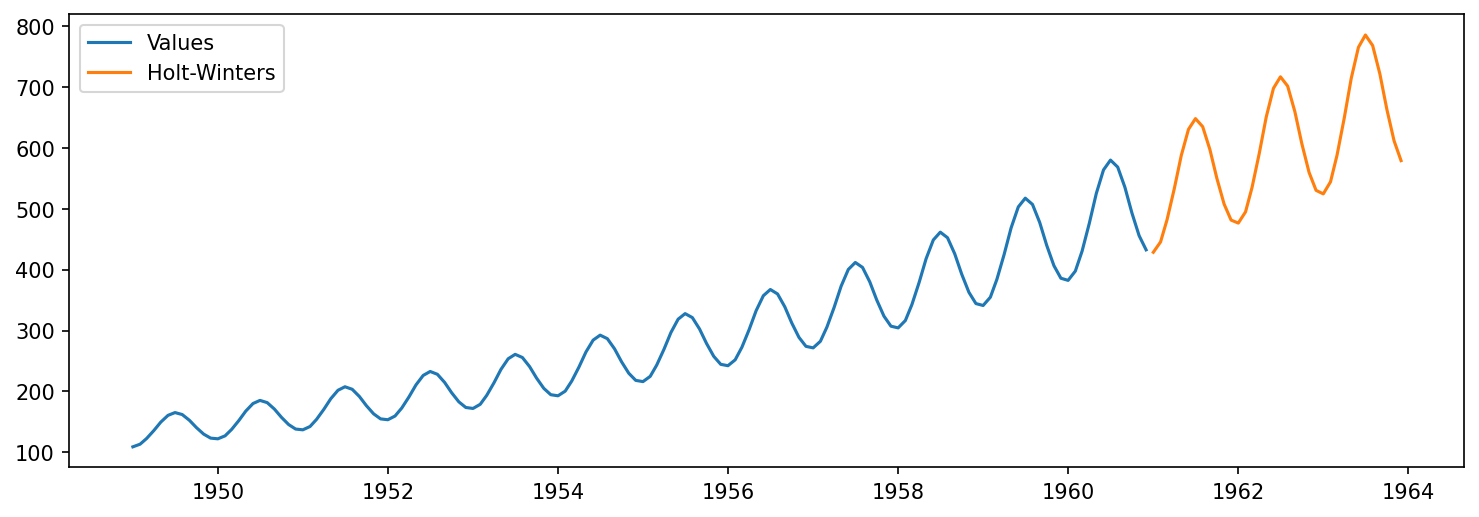

In [43]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

## One-Hot-Encoding

In [44]:
from functools import reduce
import operator

def prod(iterable):
    return reduce(operator.mul, iterable, 1)

### Данные

In [45]:
passengers = pd.read_csv('data/passengers.csv', index_col='date', parse_dates=True)

In [46]:
df = pd.get_dummies(passengers.index.month).set_index(passengers.index)

In [47]:
df["y"] = passengers["num_passengers"]

In [48]:
df.columns = [f"x{i}"for i in range(1, 13)] + ["y"]

In [49]:
df["t"] = [i for i in range(1, len(df)+1)]

In [50]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y,t
date,,,,,,,,,,,,,,
1949-01-01,1,0,0,0,0,0,0,0,0,0,0,0,112,1
1949-02-01,0,1,0,0,0,0,0,0,0,0,0,0,118,2
1949-03-01,0,0,1,0,0,0,0,0,0,0,0,0,132,3
1949-04-01,0,0,0,1,0,0,0,0,0,0,0,0,129,4
1949-05-01,0,0,0,0,1,0,0,0,0,0,0,0,121,5


### Подбор параметров

In [51]:
def mse(data, var):
    return np.mean((data["y"] - (var[0] * prod(var[i]**data[f"x{i}"] for i in range(1, 12)) * var[-1]**data["t"]))**2)

In [52]:
opfunc = lambda x: mse(df, x)

optimization = minimize(opfunc, [1 for i in range(13)])

print(optimization)
var = optimization.x

      fun: 219.7101320058256
 hess_inv: array([[ 4.50418960e-03,  4.04237975e-04,  3.02189720e-04,
         3.22899580e-04,  3.71584762e-04,  4.74110817e-04,
         5.22130617e-04,  4.90078407e-04,  4.71599871e-04,
         2.92024299e-04,  3.66317227e-04,  3.84013917e-04,
        -3.03933334e-06],
       [ 4.04237975e-04,  1.35563402e-04,  3.58319308e-05,
         2.45874435e-05,  3.14323281e-05,  3.36248566e-05,
         3.67385328e-05,  3.72104558e-05,  4.17235380e-05,
         3.64065446e-05,  2.40434260e-05,  2.14514858e-05,
        -3.01297284e-07],
       [ 3.02189720e-04,  3.58319308e-05,  1.59543325e-04,
         2.00895943e-05,  2.82139561e-05,  1.71962015e-05,
         3.90822797e-05,  5.04697706e-05,  4.37429726e-05,
         1.89151353e-05,  1.28789547e-05,  1.61547814e-06,
        -3.23774961e-07],
       [ 3.22899580e-04,  2.45874435e-05,  2.00895943e-05,
         1.24314008e-04,  2.05548166e-05,  2.42204453e-05,
         3.56735094e-05,  3.70805214e-05,  4.34326268e-0

**Среднеквадратичная ошибка**

In [53]:
print(f"MSE: {optimization.fun}")

MSE: 219.7101320058256


### Аппроксимация

In [54]:
approx = var[0] * prod(var[i]**df[f"x{i}"] for i in range(1, 12)) * var[-1]**df["t"]

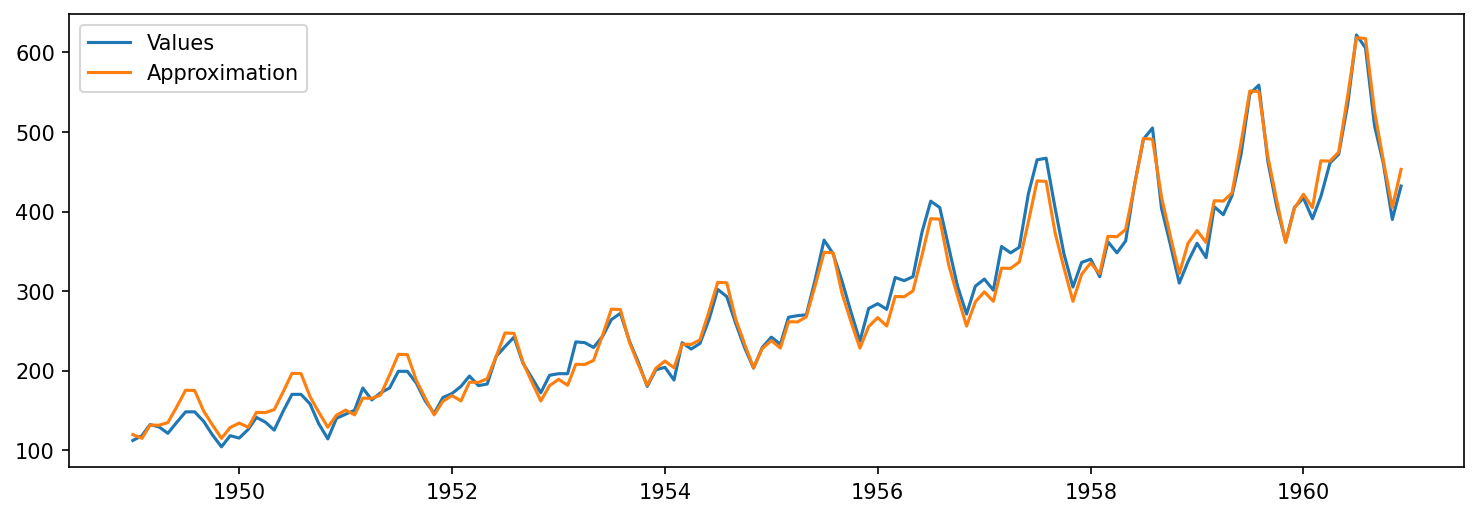

In [55]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(df["y"], label="Values")
plt.plot(approx, label="Approximation")
plt.legend()
plt.show()

### Прогноз

In [56]:
holt_winters_trend = ExponentialSmoothing(approx, initialization_method="estimated",
                                          trend="add", seasonal="mul").fit()

/home/levi/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [57]:
start = approx.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('1961-01-01 00:00:00'), Timestamp('1963-12-01 00:00:00'))

In [58]:
holt_winters_forecast = holt_winters_trend.predict(start=start, end=end)

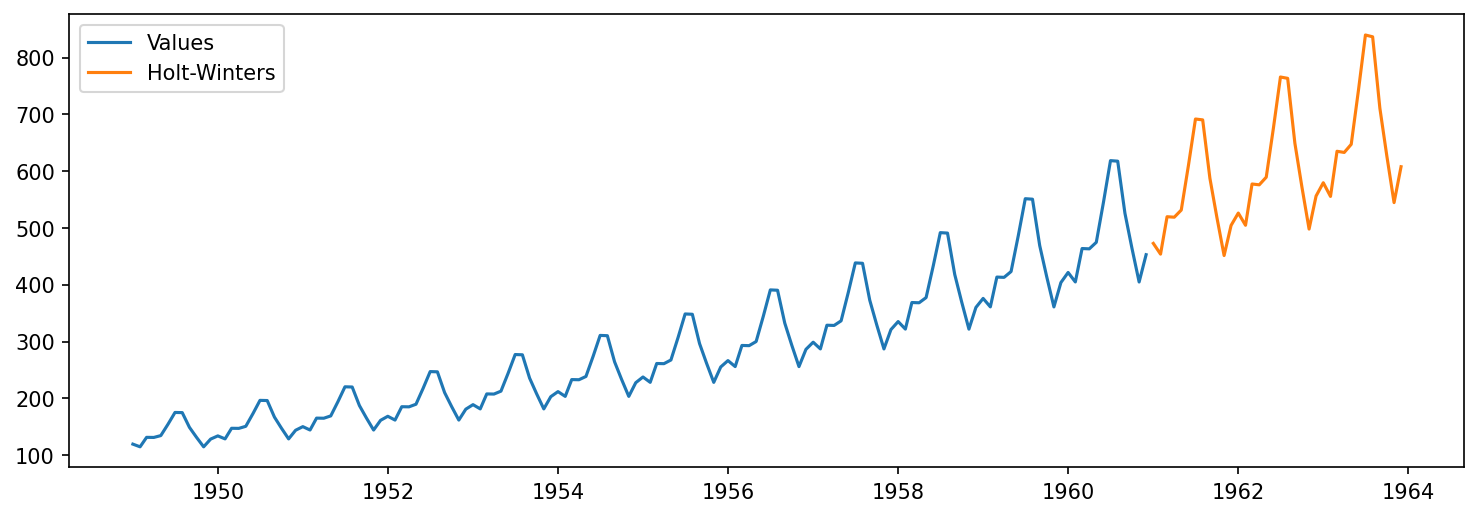

In [59]:
plt.figure(figsize=(12,4), dpi=150)
plt.plot(approx, label="Values")
plt.plot(holt_winters_forecast, label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()